In [2]:
#@title Mount drive

from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Found 11190 images belonging to 3 classes.
Found 1976 images belonging to 3 classes.
Found 2325 images belonging to 3 classes.
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv_2 (Tenso [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_2 (TensorFlo [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 6147      
Total params: 23,570,947
Trainable params: 6,147
Non-trainable params: 23,564,800
___________________________________________

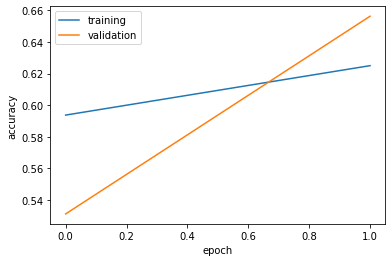

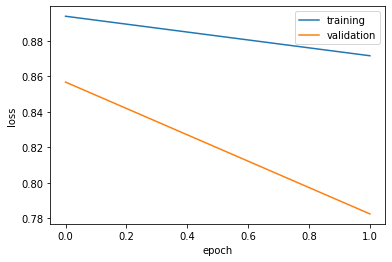

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv_2 (Tenso [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_2 (TensorFlo [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 6147      
Total params: 23,570,947
Trainable params: 23,424,515
Non-trainable params: 146,432
_________________________________________________________________
Epoch 3/4
1/1 [==============================] - ETA: 0s - loss: 0.9276 - accuracy: 0.6250
Epoch 00003

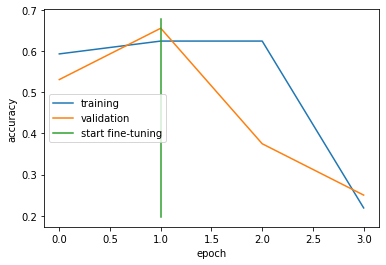

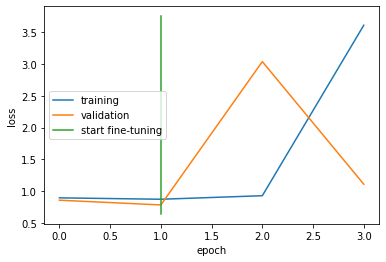

here you are


In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.models import load_model

IMAGE_SHAPE = (224, 224)
INPUT_SHAPE = IMAGE_SHAPE + (3,)
AUTO_TUNE = tf.data.experimental.AUTOTUNE


def get_dataset(dataset_path):
    dataset_get = ImageDataGenerator()
    dataset = dataset_get.flow_from_directory(dataset_path, target_size=IMAGE_SHAPE)
    return dataset


def plot_learning_curves(model_path, history, history_ft=None):
    if history_ft is not None:
        history.history['accuracy'] += history_ft.history['accuracy']
        history.history['loss'] += history_ft.history['loss']
        history.history['val_accuracy'] += history_ft.history['val_accuracy']
        history.history['val_loss'] += history_ft.history['val_loss']

    plt.plot(history.history['accuracy'], label='training')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    if history_ft is not None:
        plt.plot([history.epoch[-1], history.epoch[-1]], plt.ylim(), label='start fine-tuning')
    plt.legend()
    plt.savefig(model_path.with_name(model_path.stem + '_acc').with_suffix('.png'))

    plt.figure()
    plt.plot(history.history['loss'], label='training')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    if history_ft is not None:
        plt.plot([history.epoch[-1], history.epoch[-1]], plt.ylim(), label='start fine-tuning')
    plt.legend()
    plt.savefig(model_path.with_name(model_path.stem + '_loss').with_suffix('.png'))
    plt.show()


def train(dataset_path, model_path, logs_path):
    # build input pipeline
    train_ds = get_dataset(dataset_path / 'train')
    val_ds = get_dataset(dataset_path / 'validation')
    test_ds = get_dataset(dataset_path / 'test')
    n_classes = train_ds.num_classes

    # build model
    feature_extractor = ResNet50V2(include_top=False, pooling='avg', input_shape=INPUT_SHAPE)
    inputs = Input(shape=INPUT_SHAPE)
    x = preprocess_input(inputs)
    x = feature_extractor(x, training=False)  # training=False to keep BN layers in inference mode when unfrozen
    outputs = Dense(n_classes)(x)
    model = Model(inputs, outputs)

    # training settings
    lr = 0.001
    lr_ft = lr / 10
    epochs = 20
    epochs_ft = epochs + 10
    metrics = ['accuracy']
    loss = CategoricalCrossentropy(from_logits=True)
    callbacks = [
        ModelCheckpoint(filepath=model_path, monitor='val_accuracy', mode='max', save_best_only=True, verbose=2),
        # TensorBoard(log_dir=logs_path)
    ]

    # train only top layer (feature extraction with pre-trained convolutional base)
    feature_extractor.trainable = False
    model.compile(optimizer=Adam(lr=lr), loss=loss, metrics=metrics)
    model.summary()
    history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)
    plot_learning_curves(model_path, history)

    # fine-tune some layers
    fine_tune_at = 20
    feature_extractor.trainable = True
    for layer in feature_extractor.layers[:fine_tune_at]:
        layer.trainable = False
    model.compile(optimizer=Adam(lr=lr_ft), loss=loss, metrics=metrics)
    model.summary()
    history_ft = model.fit(train_ds, epochs=epochs_ft, initial_epoch=epochs, validation_data=val_ds, callbacks=callbacks)
    plot_learning_curves(model_path, history, history_ft)
    model.save(model_path)


def evaluate(model_path):
    load_model(model_path)
    print('here you are')
    # confusion matrix
    # cm = confusion_matrix(test_data_gen.classes, predictions)
    # ticks = np.arange(n_classes)
    # plt.figure()
    # sns.heatmap(cm, annot=True, fmt="d")
    # plt.ylabel('Actual label')
    # plt.xlabel('Predicted label')
    # plt.savefig(os.path.join(args.results, model_name + '_confusion_matrix.png'))
    # plt.show()
    #
    # # precision, recall, f1-score, accuracy, etc.
    # cr = classification_report(test_data_gen.classes, predictions, target_names=class_names)
    # print('Classification report')
    # print(cr)
    # with open(os.path.join(args.results, model_name + '_report.txt'), mode='w') as f:
    #     f.write(cr)

# prepare paths
dataset_path = Path('/content/gdrive/My Drive/DL/COVID19-project/COVIDx')
model_path = Path('/content/gdrive/My Drive/DL/COVID19-project/models') / 'try'
model_path = model_path.with_suffix('.h5')
logs_path = Path('/content/gdrive/My Drive/DL/COVID19-project/logs')
model_path.parent.mkdir(parents=True, exist_ok=True)
logs_path.mkdir(parents=True, exist_ok=True)

# train and evaluate model
if not model_path.is_file():
    train(dataset_path, model_path, logs_path)
evaluate(model_path)

# TODO: add confusion matrix and other metrics for evaluation (code commented in evaluate()) -> should suck now
# TODO: add data augmentation -> over-fitting should be reduced (i.e. test accuracy should improve)
# TODO: add resampling -> confusion matrix should improve
# TODO: add metric for cross-validation, val_acc is not adequate due to the imbalance (e.g. f1 score, but we have
#  3 classes..., google it)
# TODO: add grad-cam
# TODO: add COVID-Net
# TODO: run tests